# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
     

Mounted at /content/gdrive


In [18]:
!ls -lrt gdrive/MyDrive
!mkdir gdrive/MyDrive/CXR_Data
!cp -pr "/content/gdrive/MyDrive/CXR_data_UpGrad.zip (Unzipped Files)/effusion" /content/gdrive/MyDrive/CXR_Data
!cp -pr "/content/gdrive/MyDrive/CXR_data_UpGrad.zip (Unzipped Files)/nofinding" /content/gdrive/MyDrive/CXR_Data

total 1228748
drwx------ 2 root root      4096 Apr  6 01:54 'Colab Notebooks'
-rw------- 1 root root 823790659 Apr  6 02:01  CNN_assignment.zip
drwx------ 2 root root      4096 Apr 11 09:42 'Melanoma Detection Assignment'
drwx------ 2 root root      4096 Apr 14 01:38 'Melanoma Detection Assignment_2'
drwx------ 2 root root      4096 Apr 14 02:11 'Skin cancer ISIC The International Skin Imaging Collaboration'
-rw------- 1 root root 434417850 Apr 21 02:23  CXR_data_UpGrad.zip
drwx------ 2 root root      4096 Apr 21 02:25  Xray
drwx------ 5 root root      4096 Apr 21 02:56 'CXR_data_UpGrad.zip (Unzipped Files)'
drwx------ 3 root root      4096 Apr 21 02:59  CXR_Data
mkdir: cannot create directory ‘gdrive/MyDrive/CXR_Data’: File exists


Point a variable to the path where the data resides. Note that to use the code below you will need to move the folders effusion/ and nofinding/ into one common folder. You can do something like this:

```
mkdir CXR_Data
move effusion CXR_Data
move nofinding CXR_Data
```

In [19]:
DATASET_PATH = '/content/gdrive/MyDrive/CXR_Data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

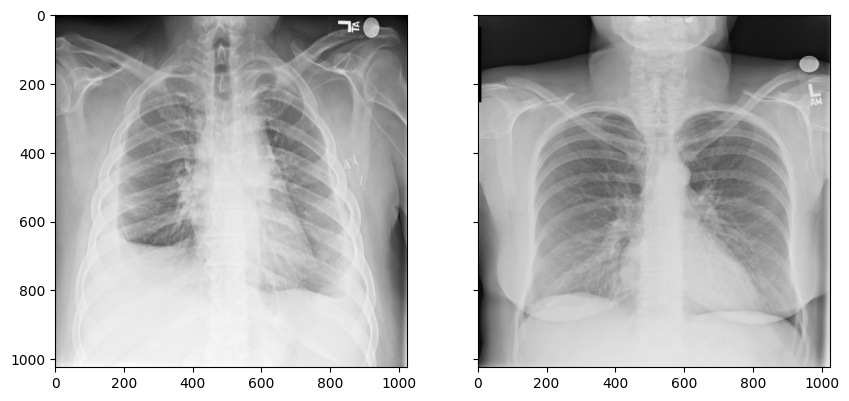

In [20]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [ ]:
effusion.shape

(1024, 1024, 4)

In [ ]:
normal.shape

(1024, 1024)

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [ ]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [ ]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [ ]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=validation_generator)

1/1 [==============================] - 0s 3ms/step - loss: 1.3989 - accuracy: 0.9667


In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 0s 1ms/step - loss: 1.7565 - accuracy: 0.1000
Epoch 2/5
1/1 [==============================] - 0s 2ms/step - loss: 1.4482 - accuracy: 0.9333
Epoch 3/5
1/1 [==============================] - 0s 1ms/step - loss: 1.3399 - accuracy: 0.9355
Epoch 4/5
1/1 [==============================] - 0s 2ms/step - loss: 1.2365 - accuracy: 0.9667
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 1.1930 - accuracy: 0.9667


In [ ]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 1.5154 - accuracy: 0.7089
Val AUC for epoch0: 0.4655172413793104
5/5 [==============================] - 11s 2s/step - loss: 1.5154 - accuracy: 0.7089 - val_loss: 2.9160 - val_accuracy: 0.9000 - val_auc: 0.4655
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 1.2867 - accuracy: 0.9177
Val AUC for epoch1: 0.41379310344827586
5/5 [==============================] - 10s 2s/step - loss: 1.2867 - accuracy: 0.9177 - val_loss: 1.8222 - val_accuracy: 0.9355 - val_auc: 0.4138
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 1.2691 - accuracy: 0.9114
Val AUC for epoch2: 0.5714285714285714
5/5 [==============================] - 10s 2s/step - loss: 1.2691 - accuracy: 0.9114 - val_loss: 1.5441 - val_accuracy: 0.9355 - val_auc: 0.5714
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 1.2725 - accuracy: 0.9057
Val AUC for epoch3: 0.48275862068965514
5/5 [==============================] - 10s 

In [ ]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=None)

1/1 [==============================] - 0s 1ms/step - loss: 5.5409 - accuracy: 0.0645


## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [ ]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 2.2712 - accuracy: 0.5725
Val AUC for epoch0: 0.5701058201058202

Epoch 00001: val_auc improved from -inf to 0.57011, saving model to models/best_model.hdf5
13/13 [==============================] - 39s 3s/step - loss: 2.2712 - accuracy: 0.5725 - val_loss: 5.3443 - val_accuracy: 0.1075 - val_auc: 0.5701
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 2.1631 - accuracy: 0.5591
Val AUC for epoch1: 0.5852941176470587

Epoch 00002: val_auc improved from 0.57011 to 0.58529, saving model to models/best_model.hdf5
13/13 [==============================] - 25s 2s/step - loss: 2.1631 - accuracy: 0.5591 - val_loss: 3.5104 - val_accuracy: 0.0968 - val_auc: 0.5853
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 2.0383 - accuracy: 0.6355
Val AUC for epoch2: 0.6411764705882352

Epoch 00003: val_auc improved from 0.58529 to 0.64118, saving model to models/best_model.hdf5
13/13 [==================

## 5. Making a Prediction

In [ ]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')

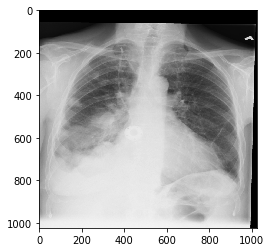

In [ ]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-8])
plt.imshow(effusion,cmap='gray')

In [ ]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.25428748, 0.7457125 ]], dtype=float32)